In [42]:
from collections import Counter
import pandas as pd
from Bio import SeqIO

In [65]:
# collect CDS features from the GenBank file into a table
rows = []
for rec in SeqIO.parse('data/mtdna_refseq.gb', 'genbank'):
    # species: prefer annotation, fallback to description
    species = rec.annotations.get('organism') or rec.description.split(',')[0]
    genus = species.split(' ')[0]
    # try to get phylum from source feature qualifiers; if not present, try taxonomy annotation

    tax = rec.annotations.get('taxonomy')

    for feat in rec.features:
        if feat.type == 'CDS':
            # gene name: prefer 'gene', then 'product', then 'locus_tag'
            gene = ''
            if 'gene' in feat.qualifiers:
                gene = feat.qualifiers['gene'][0]
            # elif 'product' in feat.qualifiers:
            #     gene = feat.qualifiers['product'][0]
            # elif 'locus_tag' in feat.qualifiers:
            #     gene = feat.qualifiers['locus_tag'][0]
            else:
                continue

            strand = '+' if feat.location.strand == 1 else ('-' if feat.location.strand == -1 else '')
            seq = str(feat.extract(rec.seq))  # nucleotide sequence of the CDS

            rows.append({
                'id': rec.id,
                'species': species,
                'genus': genus,
                'tax': tax,
                'gene name': gene,
                'strand': strand,
                'nt_sequence': seq,
                'aa_sequence': feat.qualifiers['translation'][0] if 'translation' in feat.qualifiers else ''
            })

df_cds = pd.DataFrame(rows)
df_cds.head()

,id,species,genus,tax,gene name,strand,nt_sequence,aa_sequence
0,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",CYTB,+,ATGGCAAGCCTACGAAAAACTCACCCACTACTAAAAATCGCAAACG...,MASLRKTHPLLKIANDALVDLPTPASISAWWNFGSLLGLCLISQIL...
1,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",ND1,+,ATGATCACCGCCCTACTAATTCACATCCTTAACCCCCTAGCCTTCA...,MITALLIHILNPLAFIVPVLLAVAFLTLIERKVLGYMQLRKGPNIV...
2,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",ND2,+,ATGAACCCATACATCTTAGCTACCCTACTATTTGGTCTAGGCCTAG...,MNPYILATLLFGLGLGTTITFASSHWLLAWMGLEMNTLAIIPLMAQ...
3,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",COX1,+,GTGGCAATCACACGCTGATTTTTCTCGACCAACCATAAAGACATTG...,MAITRWFFSTNHKDIGTLYLVFGAWAGMVGTALSLLIRAELSQPGA...
4,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",COX2,+,ATGGCCCATCCCACACAACTAGGATTTCAAGATGCAGCTTCACCTG...,MAHPTQLGFQDAASPVMEELLHFHDHALMIVFLISALVLYIIVAML...


In [66]:
df_species = df_cds[['id', 'species', 'genus', 'tax']].drop_duplicates('id').reset_index(drop=True)
df_species

,id,species,genus,tax
0,NC_021392.1,Scomberomorus munroi x Scomberomorus semifasci...,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
1,NC_021391.1,Scomberomorus semifasciatus,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
2,NC_021390.1,Scomberomorus munroi,Scomberomorus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
3,NC_062466.1,Diglossa brunneiventris,Diglossa,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
4,NC_030608.1,Dimidiochromis kiwinge,Dimidiochromis,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
...,...,...,...,...
150,NC_001808.1,Ceratotherium simum,Ceratotherium,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
151,NC_001700.1,Felis catus,Felis,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
152,NC_001602.1,Halichoerus grypus,Halichoerus,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."
153,NC_001601.1,Balaenoptera musculus,Balaenoptera,"[Eukaryota, Metazoa, Chordata, Craniata, Verte..."


In [67]:
df_species['tax'].apply(lambda x: x[2] if len(x) > 1 and x[1] == 'Metazoa' else None).value_counts().head(10)

tax
Chordata         65
Spiralia         25
Porifera         23
Ecdysozoa        18
Echinodermata     3
Ctenophora        1
Cnidaria          1
Hemichordata      1
Name: count, dtype: int64

In [68]:
df_cds.aa_sequence.str.len().describe()

count    2250.000000
mean      289.247556
std       167.726403
min        15.000000
25%       144.000000
50%       261.000000
75%       388.000000
max      1712.000000
Name: aa_sequence, dtype: float64

In [69]:
df_species.genus.value_counts().head(10)

genus
Pelophylax       6
Phylloscopus     5
Lycodon          4
Candida          4
Pneumocystis     3
Scincella        3
Mus              3
Anopheles        3
Scomberomorus    3
Rhipicephalus    2
Name: count, dtype: int64

In [81]:
df_cds_flt = df_cds.merge(df_species.drop_duplicates('genus').drop('tax', axis=1))
df_cds_flt = df_cds_flt[df_cds_flt.tax.apply(lambda x: x[1] == 'Metazoa')]

used_genes = df_cds_flt['gene name'].value_counts().head(14).index.values
df_cds_flt = df_cds_flt[df_cds_flt['gene name'].isin(used_genes)]

df_cds_flt.species.nunique()

109

In [82]:
df_cds_flt['gene name'].unique()

array(['CYTB', 'ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3',
       'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'ATP9'], dtype=object)

In [83]:
dataset = df_cds_flt.set_index(['species', 'gene name', 'strand']).aa_sequence.apply(Counter).apply(pd.Series).drop(['X', 'B'], axis=1).fillna(0)
dataset

M  \
species                                            gene name strand         
Scomberomorus munroi x Scomberomorus semifasciatus CYTB      +       10.0   
                                                   ND1       +       11.0   
                                                   ND2       +       18.0   
                                                   COX1      +       24.0   
                                                   COX2      +       10.0   
...                                                                   ...   
Strongylocentrotus purpuratus                      ND3       +        3.0   
                                                   ND4       +       16.0   
                                                   ND5       +       15.0   
                                                   ND6       -        4.0   
                                                   CYTB      +        7.0   

                                                                        A  \
species                                            gene name strand         
Scomberomorus munroi x Scomberomorus semifasciatus CYTB      +       31.0   
                                                   ND1       +       38.0   
                                                   ND2       +       34.0   
                                                   COX1      +       50.0   
                                                   COX2      +       19.0   
...                                                                   ...   
Strongylocentrotus purpuratus                      ND3       +       11.0   
                                                   ND4       +       44.0   
                                                   ND5       +       52.0   
                                                   ND6       -        5.0   
                                                   CYTB      +       31.0   

                                                                        S  \
species                                            gene name strand         
Scomberomorus munroi x Scomberomorus semifasciatus CYTB      +       24.0   
                                                   ND1       +       18.0   
                                                   ND2       +       27.0   
                                                   COX1      +       28.0   
                                                   COX2      +       16.0   
...                                                                   ...   
Strongylocentrotus purpuratus                      ND3       +       10.0   
                                                   ND4       +       52.0   
                                                   ND5       +       91.0   
                                                   ND6       -       22.0   
                                                   CYTB      +       26.0   

                                                                         L  \
species                                            gene name strand          
Scomberomorus munroi x Scomberomorus semifasciatus CYTB      +        60.0   
                                                   ND1       +        63.0   
                                                   ND2       +        81.0   
                                                   COX1      +        62.0   
                                                   COX2      +        29.0   
...                                                                    ...   
Strongylocentrotus purpuratus                      ND3       +        20.0   
                                                   ND4       +        81.0   
                                                   ND5       +       108.0   
                                                   ND6       -        23.0   
                                                   CYTB      +        53.0   

                                                   

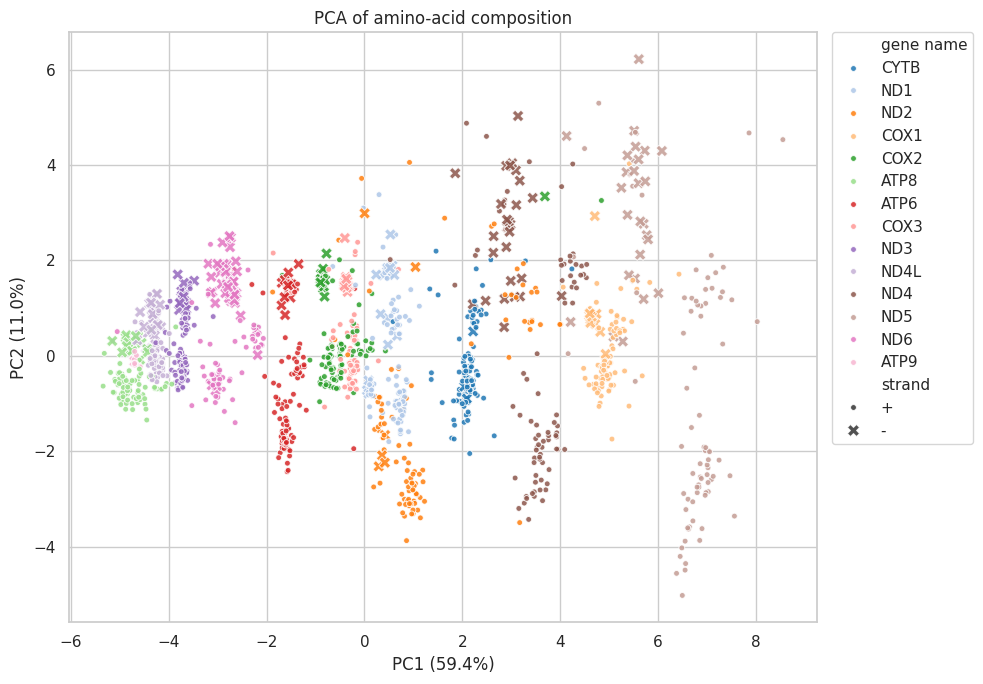

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# PCA plot of `dataset` (uses MultiIndex levels 'gene name' and 'strand' for hue/style)
import matplotlib.pyplot as plt

# prepare data
df = dataset.reset_index()  # brings 'gene name' and 'strand' into columns
features = [c for c in dataset.columns]
X = df[features].values

# scale and run PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(X_scaled)

# build plotting frame
plot_df = df[['gene name', 'strand']].copy()
plot_df['PC1'], plot_df['PC2'] = pcs[:, 0], pcs[:, 1]

# plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=plot_df,
    x='PC1', y='PC2',
    hue='gene name',
    style='strand',
    markers={'+' : '.', '-' : 'X'},
    palette='tab20',
    s=70,
    alpha=0.85
)
explained = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f'PC1 ({explained[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({explained[1]:.1f}%)')
ax.set_title('PCA of amino-acid composition')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()